In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import yfinance as yf
from datetime import datetime,time
from scipy.stats import norm, kurtosis, skew
from statistics import mean, stdev


In [92]:
options_df = pd.read_csv("AAPL_Options_Data.csv")
options_df['strike_price'] = options_df['strike_price']/1000
options_df['date'] = pd.to_datetime(options_df['date']).dt.date


In [176]:
options_df_30 = pd.read_csv("AAPL_30days.csv")
options_df_30['strike_price'] = options_df_30['strike_price']/1000
options_df_30['date'] = pd.to_datetime(options_df_30['date']).dt.date


In [177]:
options_df_30 = options_df_30[options_df_30['ticker'] == "AAPL"]
options_df_30['exdate'] = pd.to_datetime(options_df_30['exdate']).dt.date
options_df_30['Maturity'] = options_df_30['exdate']-options_df_30['date']
options_df_30['Maturity'] = options_df_30['Maturity'].dt.days.astype('int16')

#options_df_30 = options_df_30[(options_df_30['Maturity'] < 45) & (options_df_30['Maturity'] > 15)]

In [73]:
stock_df = pd.read_csv("AAPL_Stock_Data.csv")
stock_df['date'] = pd.to_datetime(stock_df['date']).dt.date

In [127]:
options_df_30[options_df_30['Maturity'] == 30]

51917     2020-09-16
51918     2020-09-16
51919     2020-09-16
51920     2020-09-16
51921     2020-09-16
             ...    
175081    2022-12-21
175083    2022-12-21
175084    2022-12-21
185510    2023-02-15
185511    2023-02-15
Name: date, Length: 160, dtype: object

In [6]:
treasury_df = yf.download('^IRX')

[*********************100%%**********************]  1 of 1 completed


In [7]:
def black_scholes_call_price(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return call_price

In [8]:
def moments(call_price_second_derivate):
  skewness_value = skew(call_price_second_derivate,axis = 0, bias = True)
  kurtosis_value = kurtosis(call_price_second_derivate,axis = 0, fisher = True, bias = True)
  return mean(call_price_second_derivate),stdev(call_price_second_derivate),skewness_value,kurtosis_value

In [83]:
def generate_pdf(options_df,stock_df,treasury_df,date):

  date = pd.to_datetime(date).date()

  reference_maturity  = 180
  sample_df = options_df[options_df['date'] == date].dropna()
  #return sample_df
  maturities = list(set(sample_df.Maturity))

  #return maturities

  nearest_maturity = ([abs(maturity - reference_maturity) for maturity in maturities])

  reference_maturity = nearest_maturity.index(min(nearest_maturity))
  sample_df = sample_df[sample_df['Maturity'] == maturities[reference_maturity] ]

  #return sample_df

  sample_df = sample_df.sort_values("strike_price")
  sample_df['Call Price'] = (sample_df['best_bid']+sample_df['best_offer'])/2
  stock_price_bk = stock_df[stock_df['date'] == date]['PRC']

  strike_prices = list(sample_df['strike_price'])
  imp_vol = list(sample_df['impl_volatility'])

  #getting the index for the spline curve for Implied Volatility Function:
  strike_at_the_money_min = ([abs(strike - stock_price_bk.values[0]) for strike in strike_prices])
  at_the_money_index = strike_at_the_money_min.index(min(strike_at_the_money_min))

  std_index = int(len(strike_prices)/6)
  strike_price_spline_index = [0,at_the_money_index-(2*std_index),at_the_money_index-(std_index),at_the_money_index,at_the_money_index+(std_index),at_the_money_index+(2*std_index),len(strike_prices)-1]

  strike_prices_spline = list(sample_df.iloc[strike_price_spline_index]['strike_price'])
  imp_vol = list(sample_df.iloc[strike_price_spline_index]['impl_volatility'])

  # Create a cubic spline interpolation of the data
  imp_vol_smooth = CubicSpline(strike_prices_spline, imp_vol)

  print("Current Data : ",date)
  strike_prices_bk = np.linspace(strike_prices[0],strike_prices[-1], num=len(strike_prices)*2)
  time_bk =  list(sample_df['Maturity'].unique())[0]/365
  rate_bk = treasury_df.loc[datetime.strptime(str(date), "%Y-%m-%d").strftime("%Y-%m-%d") ]['Adj Close']/100
  call_price_bk = []
  imp_vol_spline_data = []
  #blackscholes_prices:
  for _,strike_price in enumerate(strike_prices_bk): 
    call_price_bk.append(black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0])


  #Second Derivative with Stike(K):
  dk = 10
  call_price_second_derivate = []
  strike_derivative = np.linspace(strike_prices[0],strike_prices[-1], num=int((strike_prices[-1]-strike_prices[0])/dk))
  for i,strike_price in enumerate(strike_derivative[1:-1]):
    fxdkPrev = black_scholes_call_price(stock_price_bk,strike_derivative[i],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i])).values[0]
    fxdkNext = black_scholes_call_price(stock_price_bk,strike_derivative[i+2],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i+2])).values[0]
    fx= black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0]
    imp_vol_spline_data.append(imp_vol_smooth(strike_price))
    call_price_second_derivate.append((np.exp(-rate_bk*time_bk))*(fxdkPrev+fxdkNext-(2*fx))/(dk**2))

  return maturities[reference_maturity],strike_prices,sample_df['Call Price'],strike_prices_bk,call_price_bk,strike_derivative[1:-1],call_price_second_derivate,imp_vol_spline_data

In [86]:
maturity,strike_prices,call_prices,strike_prices_bk,call_price_bk,strike_derivative,call_price_second_derivate,imp_vol = generate_pdf(options_df,stock_df,treasury_df,"2022-07-25")

Current Data :  2022-07-25


In [87]:
#maturity,strike_prices,call_prices,strike_prices_bk,call_price_bk,strike_derivative,call_price_second_derivate,imp_vol = generate_pdf(options_df_30,stock_df,treasury_df,"2020-09-18")

2656    152.95
Name: PRC, dtype: float64
Current Data :  2022-07-25


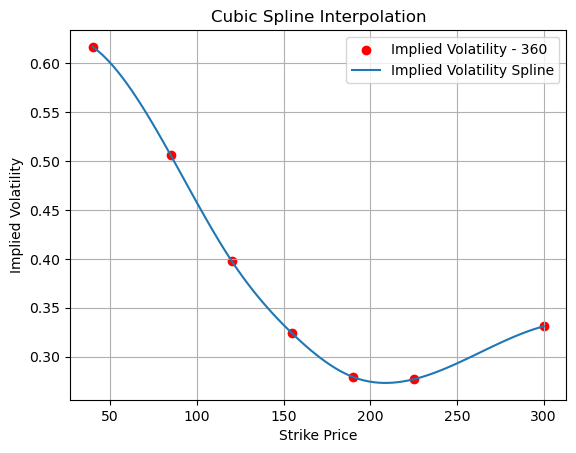

In [200]:
reference_maturity  = 360
date = '2022-07-25'
date = pd.to_datetime(date).date()
sample_df = options_df[options_df['date'] == date].dropna()
maturities = list(set(sample_df.Maturity)) 
nearest_maturity = ([abs(maturity - reference_maturity) for maturity in maturities])

reference_maturity = nearest_maturity.index(min(nearest_maturity))
sample_df = sample_df[sample_df['Maturity'] == maturities[reference_maturity] ]



sample_df = sample_df.sort_values("strike_price")
sample_df['Call Price'] = (sample_df['best_bid']+sample_df['best_offer'])/2
stock_price_bk = stock_df[stock_df['date'] == date]['PRC']
print(stock_price_bk)
strike_prices = list(sample_df['strike_price'])
imp_vol = list(sample_df['impl_volatility'])

#getting the index for the spline curve for Implied Volatility Function:
strike_at_the_money_min = ([abs(strike - stock_price_bk.values[0]) for strike in strike_prices])
at_the_money_index = strike_at_the_money_min.index(min(strike_at_the_money_min))

std_index = int(len(strike_prices)/6)
strike_price_spline_index = [0,at_the_money_index-(2*std_index),at_the_money_index-(std_index),at_the_money_index,at_the_money_index+(std_index),at_the_money_index+(2*std_index),len(strike_prices)-1]

strike_prices_spline = list(sample_df.iloc[strike_price_spline_index]['strike_price'])
imp_vol = list(sample_df.iloc[strike_price_spline_index]['impl_volatility'])


imp_vol_smooth = CubicSpline(strike_prices_spline, imp_vol)

print("Current Data : ",date)
strike_prices_bk = np.linspace(strike_prices[0],strike_prices[-1], num=len(strike_prices)*2)
time_bk =  list(sample_df['Maturity'].unique())[0]/365
rate_bk = treasury_df.loc[datetime.strptime(str(date), "%Y-%m-%d").strftime("%Y-%m-%d") ]['Adj Close']/100
call_price_bk = []
imp_vol_spline_data = []
  
for _,strike_price in enumerate(strike_prices_bk): 
    call_price_bk.append(black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0])

#Second Derivative with Stike(K):
dk = 10
call_price_second_derivate = []
call_price_new_values = []
strike_derivative = np.linspace(strike_prices[0],strike_prices[-1], num=int((strike_prices[-1]-strike_prices[0])/dk))
for i,strike_price in enumerate(strike_derivative[1:-1]):
    fxdkPrev = black_scholes_call_price(stock_price_bk,strike_derivative[i],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i])).values[0]
    fxdkNext = black_scholes_call_price(stock_price_bk,strike_derivative[i+2],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i+2])).values[0]
    fx= black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0]
    imp_vol_spline_data.append(imp_vol_smooth(strike_price))
    call_price_second_derivate.append((np.exp(-rate_bk*time_bk))*(fxdkPrev+fxdkNext-(2*fx))/(dk**2))
    call_price_new_values.append(fx)

# Plot the original data points
plt.scatter(strike_prices_spline, imp_vol, label='Implied Volatility - 360 ',c='r')

# Plot the cubic spline curve
plt.plot(strike_prices_bk, imp_vol_smooth(strike_prices_bk), label='Implied Volatility Spline')

# Add labels and legend
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Cubic Spline Interpolation')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
   
#plt.plot(strike_prices,call_prices)
#plt.plot(strike_prices_bk,call_price_bk)


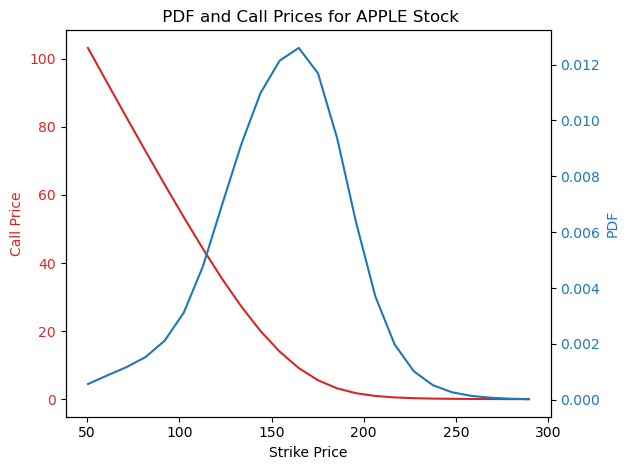

In [163]:
# Create some mock data

fig, ax1 = plt.subplots()
plt.title(" PDF and Call Prices for APPLE Stock")
color = 'tab:red'
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price', color=color)
ax1.plot(strike_derivative[1:-1], call_price_new_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PDF', color=color)  # we already handled the x-label with ax1
ax2.plot(strike_derivative[1:-1], call_price_second_derivate, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#plt.plot(strike_prices,call_prices)
#plt.plot(strike_derivative,call_price_second_derivate)
plt.show()

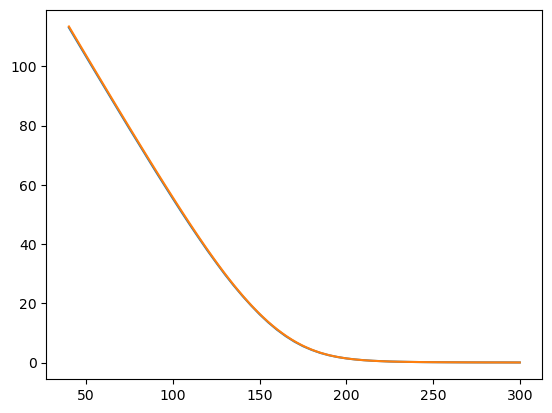

In [15]:
plt.plot(strike_prices,call_prices)
plt.plot(strike_prices_bk,call_price_bk)
plt.show()

In [ ]:
print("Area under PDF : ",sum((call_price_second_derivate)*10))
mean_value,std_value,skew_value,kurtosis_value = moments(call_price_second_derivate)
moments_df = pd.DataFrame([mean_value,std_value,skew_value,kurtosis_value]).T
moments_df.columns = ['Mean','Std','Skewness','Kurtosis']
moments_df.index = [date+" ("+str(maturity)+")"]
moments_df

Area under PDF :  1.0262280890165043


,Mean,Std,Skewness,Kurtosis
2019-02-19 (150),0.005401,0.006058,0.761773,-0.998644


In [202]:
dates = '2021-01-07'
#for date in dates:
reference_maturity  = 30
date = '2022-07-25'
date = pd.to_datetime(date).date()
sample_df = options_df_30[options_df_30['date'] == date].dropna()
maturities = list(set(sample_df.Maturity)) 
nearest_maturity = ([abs(maturity - reference_maturity) for maturity in maturities])
print(nearest_maturity)
reference_maturity = nearest_maturity.index(min(nearest_maturity))
sample_df = sample_df[sample_df['Maturity'] == maturities[reference_maturity] ]


sample_df = sample_df.sort_values("strike_price")
sample_df['Call Price'] = (sample_df['best_bid']+sample_df['best_offer'])/2
stock_price_bk = stock_df[stock_df['date'] == date]['PRC']

strike_prices = list(sample_df['strike_price'])
imp_vol = list(sample_df['impl_volatility'])

    #print(sample_df)
    #print(imp_vol)

#strike_price_spline_index = [0, 6, 13, 19, 26, 32, 39, 45, 52, 59]
strike_prices_spline = list(sample_df.iloc[strike_price_spline_index]['strike_price'])
imp_vol = list(sample_df.iloc[strike_price_spline_index]['impl_volatility'])


imp_vol_smooth = CubicSpline(strike_prices_spline, imp_vol)
    
#imp_vol_smooth = CubicSpline(strike_prices, imp_vol)
print(stock_price_bk)
print("Current Data : ",date)
strike_prices_bk = np.linspace(strike_prices[0],strike_prices[-1], num=len(strike_prices)*2)
time_bk =  list(sample_df['Maturity'].unique())[0]/365
rate_bk = treasury_df.loc[datetime.strptime(str(date), "%Y-%m-%d").strftime("%Y-%m-%d") ]['Adj Close']/100
call_price_bk = []
imp_vol_spline_data = []

for _,strike_price in enumerate(strike_prices_bk): 
    call_price_bk.append(black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0])


#Second Derivative with Stike(K):
dk = 10
call_price_second_derivate = []
call_price_new_values = []
strike_derivative = np.linspace(strike_prices[0],strike_prices[-1], num=int((strike_prices[-1]-strike_prices[0])/dk))
for i,strike_price in enumerate(strike_derivative[1:-1]):
    fxdkPrev = black_scholes_call_price(stock_price_bk,strike_derivative[i],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i])).values[0]
    fxdkNext = black_scholes_call_price(stock_price_bk,strike_derivative[i+2],time_bk,rate_bk,0,imp_vol_smooth(strike_derivative[i+2])).values[0]
    fx= black_scholes_call_price(stock_price_bk,strike_price,time_bk,rate_bk,0,imp_vol_smooth(strike_price)).values[0]
    imp_vol_spline_data.append(imp_vol_smooth(strike_price))
    call_price_second_derivate.append((np.exp(-rate_bk*time_bk))*(fxdkPrev+fxdkNext-(2*fx))/(dk**2))
    call_price_new_values.append(fx)
    
    
# Plot the original data points
plt.scatter(strike_prices_spline, imp_vol, label='Implied Volatility - 30 ',c='r')

# Plot the cubic spline curve
plt.plot(strike_prices_bk, imp_vol_smooth(strike_prices_bk), label='Implied Volatility Spline')

# Add labels and legend
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Cubic Spline Interpolation')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

    #plt.plot(strike_prices,call_prices)
#plt.plot(strike_prices_bk,call_price_bk)


[2, 5, 12, 9]


IndexError: positional indexers are out-of-bounds

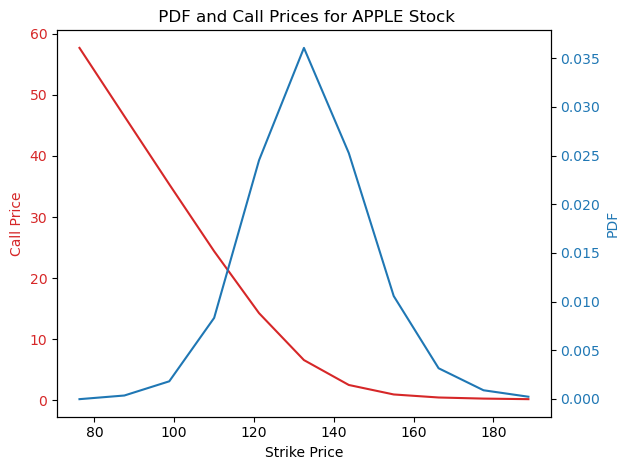

In [198]:
# Create some mock data

fig, ax1 = plt.subplots()
plt.title(" PDF and Call Prices for APPLE Stock")
color = 'tab:red'
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Call Price', color=color)
ax1.plot(strike_derivative[1:-1], call_price_new_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PDF', color=color)  # we already handled the x-label with ax1
ax2.plot(strike_derivative[1:-1], call_price_second_derivate, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#plt.plot(strike_prices,call_prices)
#plt.plot(strike_derivative,call_price_second_derivate)
plt.show()

In [193]:
[int(i) for i in list(np.linspace(0,59,10))]

[0, 6, 13, 19, 26, 32, 39, 45, 52, 59]

In [206]:
stat_return = pd.read_excel("Stratreturn.xlsx",sheet_name="Returns")

,Unnamed: 0,Future Date,SPX100 Eq Wt.,30D_Top5,30D_Bottom5,360D_Top5,360D_Bottom5
0,NaT,2018-01-31,100.000000,100.000000,100.000000,100.000000,100.000000
1,2018-01-31,2018-03-02,94.100228,99.016302,100.917076,96.846366,99.868134
2,2018-03-02,2018-04-01,92.435264,95.286335,95.895212,95.296994,97.737982
3,2018-04-02,2018-05-02,91.552276,97.359577,100.109193,97.880743,103.646220
4,2018-05-02,2018-06-01,94.528087,103.540917,106.296329,104.645662,107.971008
...,...,...,...,...,...,...,...
56,2022-08-26,2022-09-25,121.747847,179.389676,165.426198,219.816899,141.636616
57,2022-09-26,2022-10-26,128.138083,194.527262,198.201677,223.886470,159.584778
58,2022-10-26,2022-11-25,137.606293,216.435707,219.925458,234.599171,170.431333
59,2022-11-25,2022-12-25,132.502324,206.500261,216.805650,233.204961,160.709331


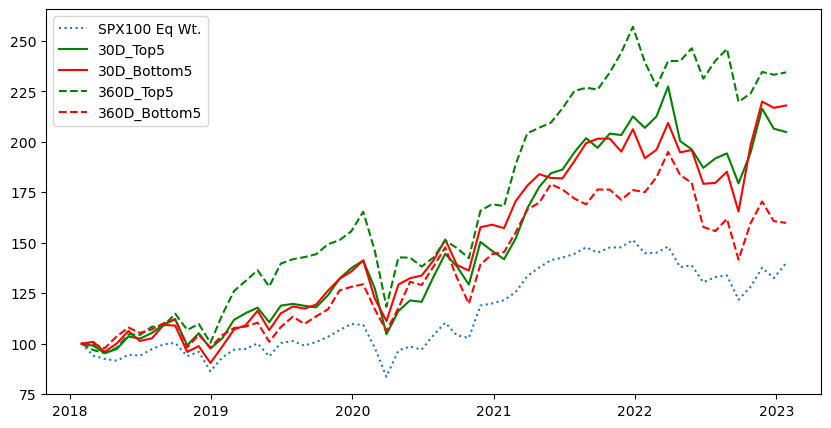

In [247]:
cols = stat_return.columns[2:]
plt.figure(figsize=(10,5))
colors = ['']
index_360 = 1
index_30 = 1
for i,col in enumerate(cols):
    if i == 0:
        plt.plot(stat_return['Future Date'],stat_return[col],linestyle='dotted',color='tab:blue')
        #plt.annotate()
    elif '30D' in col:
        if index_30 == 1:
            index_30 += 1
            plt.plot(stat_return['Future Date'],stat_return[col],color='g')
        else:
            plt.plot(stat_return['Future Date'],stat_return[col],color='r')
    else:
        if index_360 == 1:
            index_360 += 1
            plt.plot(stat_return['Future Date'],stat_return[col],linestyle='dashed',color='g')
        else:
            plt.plot(stat_return['Future Date'],stat_return[col],linestyle='dashed',color='r')
#plt.title(" 30/360 RNS Top 5 vs Bottom 5")
#plt.grid(True)
plt.legend(cols)
plt.savefig("StatReturn.png")


In [216]:
xytext=(3, 1.5)

Index(['Unnamed: 0', 'Future Date', 'SPX100 Eq Wt.', '30D_Top5', '30D_Bottom5',
       '360D_Top5', '360D_Bottom5'],
      dtype='object')

KeyError: -1